### Importing Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import shutil

### Specifying Image Size, Batch Size, Epochs, Channels

In [4]:
Image_Size = 256
Batch_Size = 64
Channels = 3
Epochs = 50

### Loading Dataset

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data",
    shuffle = True,
    image_size = (Image_Size, Image_Size),
    batch_size = Batch_Size
)

Found 1311 files belonging to 4 classes.


### Class Names

In [6]:
classes = dataset.class_names
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

### Length of Dataset

In [7]:
len(dataset)

21

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[1 2 0 0 3 1 0 0 1 1 1 1 1 0 2 1 3 2 0 1 2 0 2 3 3 2 2 0 2 2 2 3 0 1 3 2 2
 2 2 1 3 2 1 2 0 2 2 1 3 3 2 0 2 2 2 1 1 0 1 3 2 0 1 2]


### Data Visualization

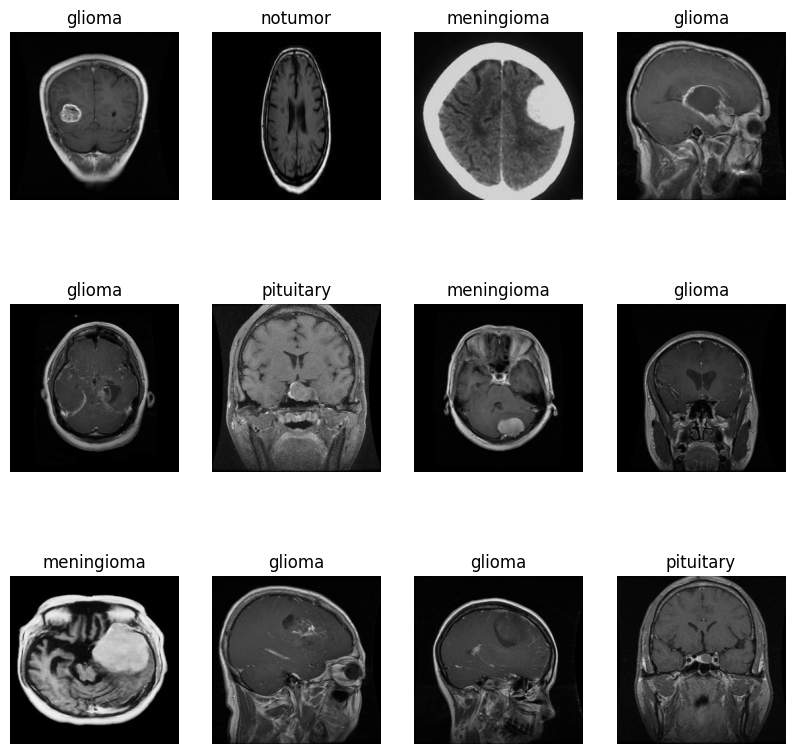

In [9]:
plt.figure(num=10, figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

### Train Test Split - 

80% --> Training, 10% --> Validation, 10% --> Testing 

In [10]:
def dataset_get_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = dataset_get_partitions_tf(dataset)

In [13]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

16
2
3


### Shuffling Data

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Resize and Rescale Layer

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation Layer

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Building

In [18]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(4, activation='softmax')
])

### Model Summary

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)       

### Setting up Learning Rate and Optimizer

In [21]:
# Implement learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### Compiling the Model

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

### Setting up Early Stopping

In [24]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

### Training Model

In [25]:
# Train the model with more epochs
history = model.fit(
    train_ds,
    epochs=Epochs,  # Increase the number of epochs
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
16/16 [==============================] - 42s 2s/step - loss: 15.1571 - accuracy: 0.2959 - val_loss: 1.1619 - val_accuracy: 0.4062
Epoch 2/50
16/16 [==============================] - 36s 2s/step - loss: 1.0569 - accuracy: 0.5078 - val_loss: 1.0149 - val_accuracy: 0.4609
Epoch 3/50
16/16 [==============================] - 36s 2s/step - loss: 0.8747 - accuracy: 0.6279 - val_loss: 0.7124 - val_accuracy: 0.7266
Epoch 4/50
16/16 [==============================] - 36s 2s/step - loss: 0.6963 - accuracy: 0.7334 - val_loss: 0.6834 - val_accuracy: 0.6875
Epoch 5/50
16/16 [==============================] - 37s 2s/step - loss: 0.5496 - accuracy: 0.7822 - val_loss: 0.4654 - val_accuracy: 0.8281
Epoch 6/50
16/16 [==============================] - 36s 2s/step - loss: 0.4473 - accuracy: 0.8223 - val_loss: 0.5427 - val_accuracy: 0.7734
Epoch 7/50
16/16 [==============================] - 36s 2s/step - loss: 0.4070 - accuracy: 0.8301 - val_loss: 0.3864 - val_accuracy: 0.8516
Epoch 8/50
16/16 [=

In [27]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(test_ds)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


3/3 [==============================] - 4s 652ms/step - loss: 0.1050 - accuracy: 0.9688
Validation Accuracy: 96.88%


### Evaluating Model on test data

In [32]:
# Save the model
model.save('brain-model.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plotting Loss and Accuracy Curve

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

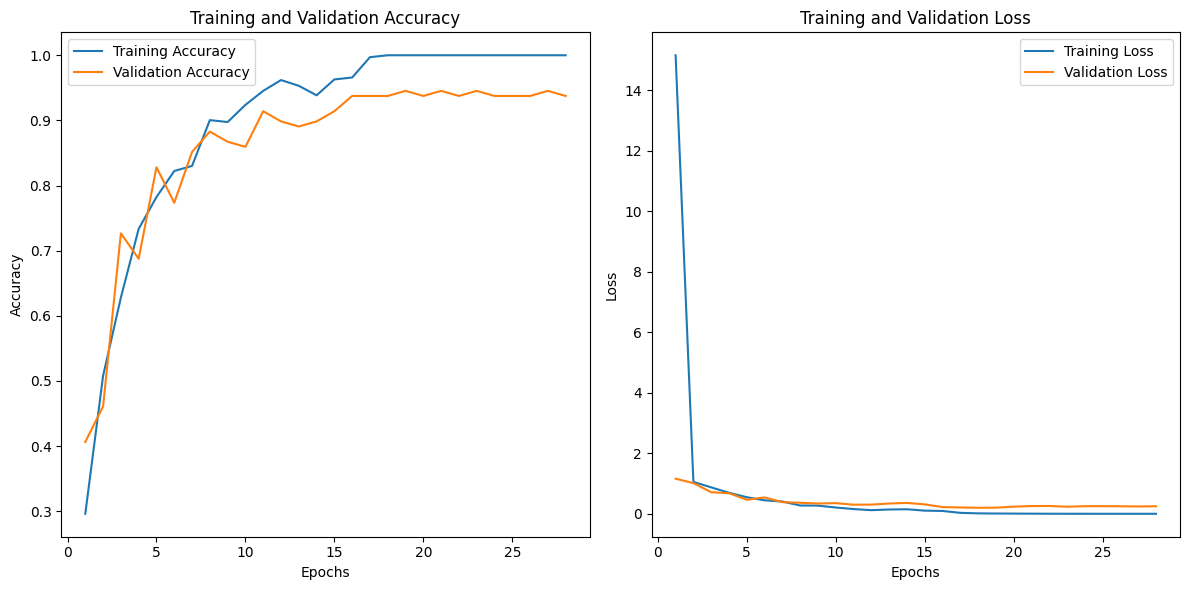

In [30]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Looking at Predictions

2/2 [==============================] - 1s 302ms/step


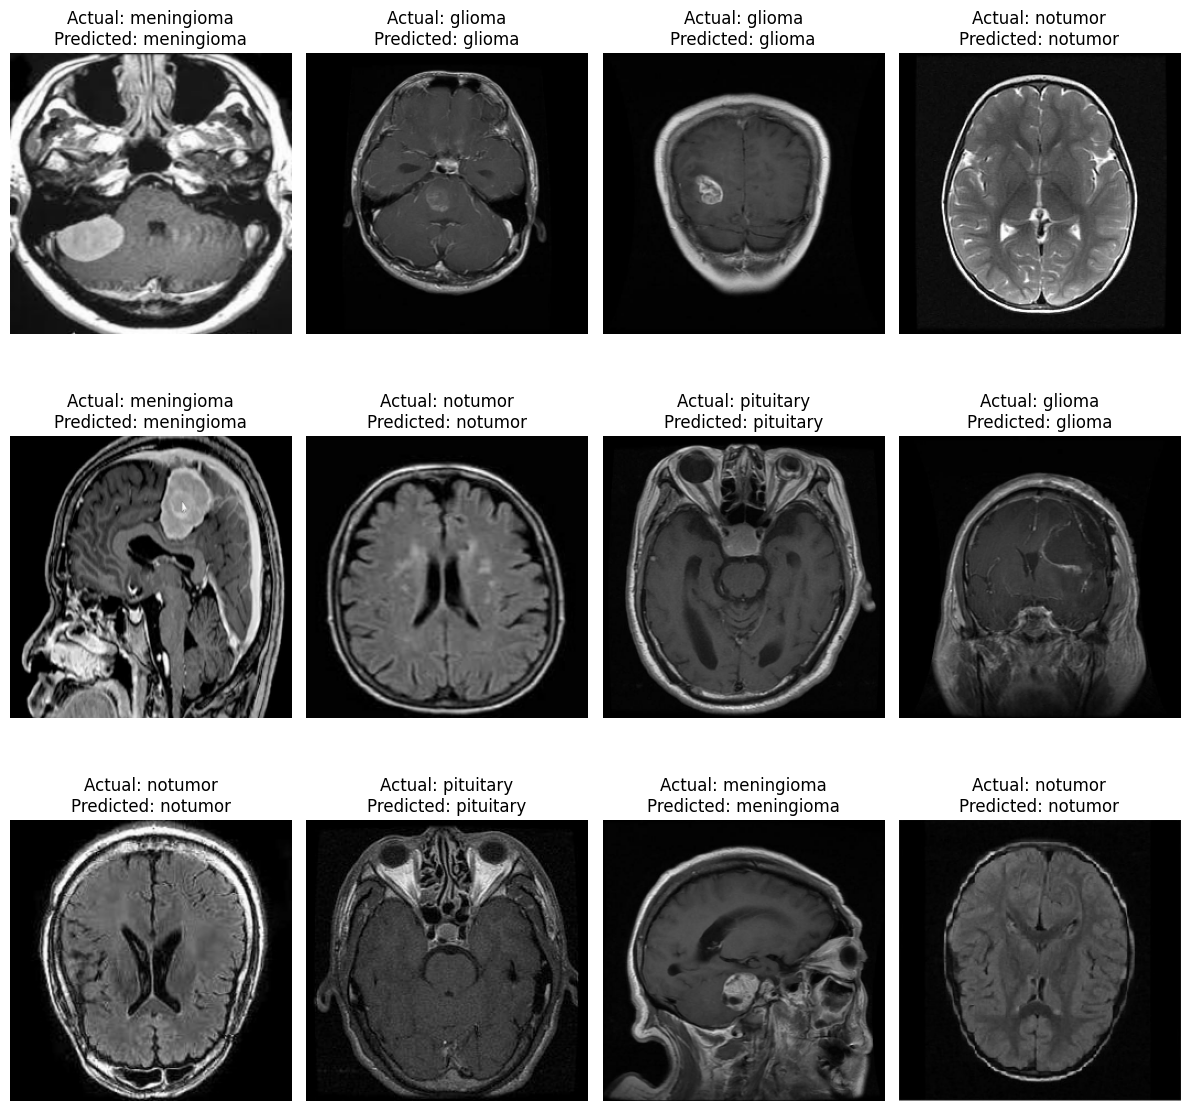

In [31]:
# Get some random samples from the test dataset
sample_images = []
sample_labels = []
for images, labels in test_ds.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()

# Make predictions on the random samples
predictions = model.predict(sample_images)

# Visualize random samples with actual and predicted labels
num_samples = len(sample_images)
num_rows = 3
num_cols = 4
plt.figure(figsize=(12, 12))
for i in range(min(num_samples, num_rows * num_cols)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    actual_label = classes[sample_labels[i]]
    predicted_label = classes[np.argmax(predictions[i])]
    title = f"Actual: {actual_label}\nPredicted: {predicted_label}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()
